# ORF recognition by LSTM
LSTM was incapable of ORF recognition on 1000 bp sequences. Try smaller.


In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-05-18 23:21:38 UTC'

In [2]:
PC_SEQUENCES=20000   # how many protein-coding sequences
NC_SEQUENCES=20000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
BASES=100            # how long is each sequence
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (BASES,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (BASES,ALPHABET) # Conv1D needs 2D inputs
NEURONS = 32
#DROP_RATE = 0.2
EPOCHS=50  # how many times to train on all the data
SPLITS=5  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=5  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import *
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import LSTM,GRU,SimpleRNN
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
# Use code from our SimTools library.
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen
def get_the_facts(seqs):
    rd = RNA_describer()
    facts = rd.get_three_lengths(seqs)
    facts_ary = np.asarray(facts) # 5000 rows, 3 columns 
    print("Facts array:",type(facts_ary))
    print("Facts array:",facts_ary.shape)
    # Get the mean of each column
    mean_5utr, mean_orf, mean_3utr = np.mean(facts_ary,axis=0)
    std_5utr, std_orf, std_3utr = np.std(facts_ary,axis=0)
    print("mean 5' UTR length:",int(mean_5utr),"+/-",int(std_5utr))
    print("mean    ORF length:",int(mean_orf), "+/-",int(std_orf))
    print("mean 3' UTR length:",int(mean_3utr),"+/-",int(std_3utr))

pc_sim,nc_sim = make_generators(BASES)
pc_train = pc_sim.get_sequences(PC_SEQUENCES)
nc_train = nc_sim.get_sequences(NC_SEQUENCES)
print("Train on",len(pc_train),"PC seqs")
get_the_facts(pc_train)
print("Train on",len(nc_train),"NC seqs")
get_the_facts(nc_train)

Train on 20000 PC seqs
Facts array: <class 'numpy.ndarray'>
Facts array: (20000, 3)
mean 5' UTR length: 23 +/- 6
mean    ORF length: 51 +/- 10
mean 3' UTR length: 25 +/- 5
Train on 20000 NC seqs
Facts array: <class 'numpy.ndarray'>
Facts array: (20000, 3)
mean 5' UTR length: 40 +/- 18
mean    ORF length: 16 +/- 22
mean 3' UTR length: 42 +/- 18


In [6]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [7]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=ALPHABET, output_dim=ALPHABET))
        #VOCABULARY_SIZE, EMBED_DIMEN, input_length=1000, input_length=1000, mask_zero=True)
        #input_dim=[None,VOCABULARY_SIZE], output_dim=EMBED_DIMEN, mask_zero=True)
    dnn.add(GRU(NEURONS,return_sequences=True,input_shape=INPUT_SHAPE))
    dnn.add(GRU(NEURONS,return_sequences=False)) 
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build() # input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (100, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100, 32)           3648      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 11,073
Trainable params: 11,073
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 29s 11ms/step - loss: 0.6944 - accuracy: 0.4964 - val_loss: 0.6935 - val_accuracy: 0.4999


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6937 - accuracy: 0.5010 - val_loss: 0.6935 - val_accuracy: 0.4999
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6937 - accuracy: 0.4981 - val_loss: 0.6934 - val_accuracy: 0.4999
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6934 - accuracy: 0.5059 - val_loss: 0.6932 - val_accuracy: 0.5001


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6935 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6935 - accuracy: 0.5014 - val_loss: 0.6937 - val_accuracy: 0.4999
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6937 - accuracy: 0.4993 - val_loss: 0.6942 - val_accuracy: 0.5001
Epoch 8/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6935 - accuracy: 0.5040 - val_loss: 0.6940 - val_accuracy: 0.4999
Epoch 9/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6937 - accuracy: 0.5003 - val_loss: 0.6934 - val_accuracy: 0.5001
Epoch 10/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6934 - accuracy: 0.5063 - val_loss: 0.6932 - val_accuracy: 0.5001
Epoch 11/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6935 - accuracy: 0.4971 - val_loss: 0.6935

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 18/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6935 - accuracy: 0.5034 - val_loss: 0.6939 - val_accuracy: 0.5001
Epoch 19/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6938 - accuracy: 0.4988 - val_loss: 0.6936 - val_accuracy: 0.5044


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 20/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6934 - accuracy: 0.5021 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 21/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6933 - accuracy: 0.5040 - val_loss: 0.6932 - val_accuracy: 0.4976
Epoch 22/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6934 - accuracy: 0.5037 - val_loss: 0.6937 - val_accuracy: 0.4961
Epoch 23/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6933 - accuracy: 0.5010 - val_loss: 0.6940 - val_accuracy: 0.4967
Epoch 24/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6930 - accuracy: 0.5126 - val_loss: 0.6936 - val_accuracy: 0.4997
Epoch 25/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6933 - accuracy: 0.5038 - val_loss: 0.6938 - val_accuracy: 0.4999
Epoch 26/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6932 - accuracy: 0.5090 - val_loss: 0

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 28/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6194 - accuracy: 0.6581 - val_loss: 0.3573 - val_accuracy: 0.8572


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 29/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3494 - accuracy: 0.8588 - val_loss: 0.3316 - val_accuracy: 0.8643


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 30/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3305 - accuracy: 0.8637 - val_loss: 0.3476 - val_accuracy: 0.8594
Epoch 31/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3135 - accuracy: 0.8697 - val_loss: 0.2887 - val_accuracy: 0.8808


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 32/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2889 - accuracy: 0.8839 - val_loss: 0.2554 - val_accuracy: 0.9051


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 33/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2559 - accuracy: 0.9044 - val_loss: 0.2313 - val_accuracy: 0.9160


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 34/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2283 - accuracy: 0.9194 - val_loss: 0.2158 - val_accuracy: 0.9260


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 35/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2226 - accuracy: 0.9216 - val_loss: 0.2206 - val_accuracy: 0.9239
Epoch 36/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2122 - accuracy: 0.9272 - val_loss: 0.1950 - val_accuracy: 0.9367


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 37/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2024 - accuracy: 0.9319 - val_loss: 0.2068 - val_accuracy: 0.9311
Epoch 38/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1941 - accuracy: 0.9360 - val_loss: 0.2031 - val_accuracy: 0.9315
Epoch 39/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1916 - accuracy: 0.9374 - val_loss: 0.1836 - val_accuracy: 0.9414


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 40/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1826 - accuracy: 0.9395 - val_loss: 0.1800 - val_accuracy: 0.9430


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 41/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1798 - accuracy: 0.9399 - val_loss: 0.1756 - val_accuracy: 0.9424
Epoch 42/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1701 - accuracy: 0.9464 - val_loss: 0.1723 - val_accuracy: 0.9436


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 43/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1787 - accuracy: 0.9416 - val_loss: 0.1729 - val_accuracy: 0.9473


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 44/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1757 - accuracy: 0.9425 - val_loss: 0.1742 - val_accuracy: 0.9431
Epoch 45/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1649 - accuracy: 0.9460 - val_loss: 0.1620 - val_accuracy: 0.9507


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 46/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1571 - accuracy: 0.9503 - val_loss: 0.1529 - val_accuracy: 0.9521


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 47/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1525 - accuracy: 0.9515 - val_loss: 0.1525 - val_accuracy: 0.9540


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 48/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1591 - accuracy: 0.9494 - val_loss: 0.1517 - val_accuracy: 0.9532
Epoch 49/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1507 - accuracy: 0.9522 - val_loss: 0.1882 - val_accuracy: 0.9379
Epoch 50/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1525 - accuracy: 0.9519 - val_loss: 0.1485 - val_accuracy: 0.9539
Fold 1, 50 epochs, 687 sec


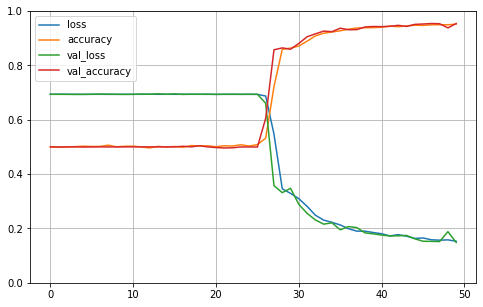

MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 13s 11ms/step - loss: 0.6965 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.5005
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6934 - accuracy: 0.5056 - val_loss: 0.6933 - val_accuracy: 0.4995
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6937 - accuracy: 0.4919 - val_loss: 0.6949 - val_accuracy: 0.4995
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6940 - accuracy: 0.4946 - val_loss: 0.6933 - val_accuracy: 0.4958
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6934 - accuracy: 0.5078 - val_loss: 0.6934 - val_accuracy: 0.4995
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6936 - accuracy: 0.5008 - val_loss: 0.6933 - val_accuracy: 0.4938
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.693

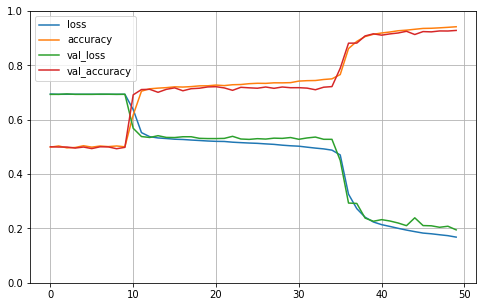

MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 14s 11ms/step - loss: 0.6955 - accuracy: 0.5045 - val_loss: 0.6933 - val_accuracy: 0.4986
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6936 - accuracy: 0.4998 - val_loss: 0.6933 - val_accuracy: 0.5014
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6937 - accuracy: 0.4983 - val_loss: 0.6937 - val_accuracy: 0.4986
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6937 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.5014
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6936 - accuracy: 0.5016 - val_loss: 0.6973 - val_accuracy: 0.4986
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6942 - accuracy: 0.4926 - val_loss: 0.6936 - val_accuracy: 0.4941
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.693

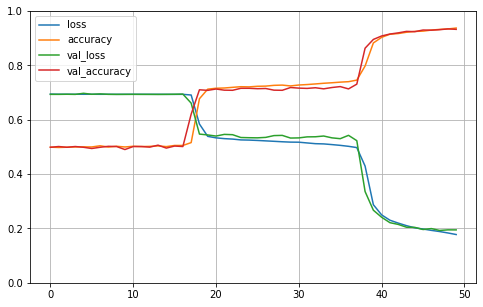

MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 13s 11ms/step - loss: 0.6938 - accuracy: 0.4967 - val_loss: 0.6936 - val_accuracy: 0.5040
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6937 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6934 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.5040
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6939 - accuracy: 0.4960 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6936 - accuracy: 0.5045 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6937 - accuracy: 0.4949 - val_loss: 0.6941 - val_accuracy: 0.4960
Epoch 7/50
1000/1000 [==============================] - 11s 11ms/step - loss: 0.693

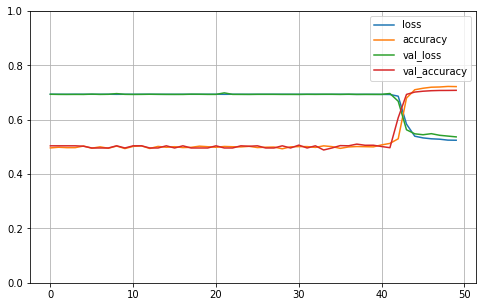

MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 14s 11ms/step - loss: 0.6939 - accuracy: 0.4966 - val_loss: 0.6944 - val_accuracy: 0.4970
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6938 - accuracy: 0.5002 - val_loss: 0.6934 - val_accuracy: 0.4970
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6935 - accuracy: 0.5006 - val_loss: 0.6942 - val_accuracy: 0.5030
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6935 - accuracy: 0.5066 - val_loss: 0.6942 - val_accuracy: 0.4970
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6935 - accuracy: 0.5029 - val_loss: 0.6945 - val_accuracy: 0.4970
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6937 - accuracy: 0.5020 - val_loss: 0.6940 - val_accuracy: 0.5030
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.689

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 35/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1512 - accuracy: 0.9511 - val_loss: 0.1806 - val_accuracy: 0.9385
Epoch 36/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1491 - accuracy: 0.9520 - val_loss: 0.1847 - val_accuracy: 0.9406
Epoch 37/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1518 - accuracy: 0.9503 - val_loss: 0.1608 - val_accuracy: 0.9495
Epoch 38/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1467 - accuracy: 0.9530 - val_loss: 0.1581 - val_accuracy: 0.9511
Epoch 39/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1479 - accuracy: 0.9513 - val_loss: 0.1431 - val_accuracy: 0.9535
Epoch 40/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1630 - accuracy: 0.9478 - val_loss: 0.1732 - val_accuracy: 0.9435
Epoch 41/50
1000/1000 [==============================] - 11s 11ms/step - loss: 0.1399 - accuracy: 0.9551 - val_loss: 0

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 43/50
1000/1000 [==============================] - 11s 11ms/step - loss: 0.1416 - accuracy: 0.9554 - val_loss: 0.1413 - val_accuracy: 0.9559
Epoch 44/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1435 - accuracy: 0.9540 - val_loss: 0.1646 - val_accuracy: 0.9523
Epoch 45/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1488 - accuracy: 0.9514 - val_loss: 0.1485 - val_accuracy: 0.9525
Epoch 46/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1378 - accuracy: 0.9555 - val_loss: 0.1459 - val_accuracy: 0.9541
Epoch 47/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1367 - accuracy: 0.9565 - val_loss: 0.1434 - val_accuracy: 0.9563
Epoch 48/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1390 - accuracy: 0.9548 - val_loss: 0.1493 - val_accuracy: 0.9540
Epoch 49/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1398 - accuracy: 0.9559 - val_loss: 0

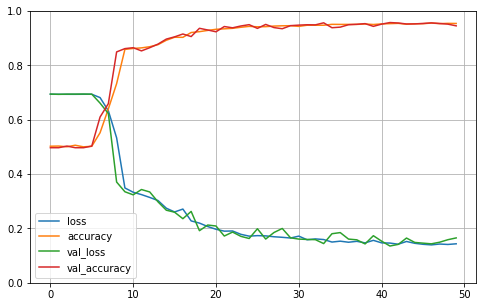

In [9]:
do_cross_validation(X,y)

In [10]:
from keras.models import load_model
pc_sim.set_reproducible(True)
nc_sim.set_reproducible(True)
pc_test = pc_sim.get_sequences(PC_TESTS)
nc_test = nc_sim.get_sequences(NC_TESTS)
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 96.20%


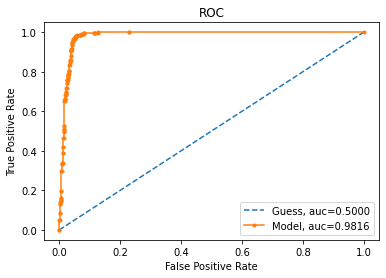

AUC: 0.98%


In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc))


In [12]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-05-19 00:08:16 UTC'